In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from ase.build import bulk
from gpaw import GPAW, PW, FermiDirac
from ase.build import mx2
%matplotlib inline

N=8 # сетка по импульсам
DFT_ecut=550
nbands=10 # количество свободных зон в расчете
vacuum=10 # вакуум по вертикали между слоями в ангстремах (в уме умножай на два)

layer = mx2(vacuum=vacuum)
layer.pbc[2]=True
calc = GPAW(mode=PW(DFT_ecut),
            xc='PBE',
            kpts=(N,N, 1),
            occupations=FermiDirac(0.005),
            setups='sg15',
            nbands=-nbands)
layer.calc = calc
layer.get_potential_energy()


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.4.0
 |___|_|             

User:   yzhumagulov@cpqm1
Date:   Fri Feb  8 13:55:46 2019
Arch:   x86_64
Pid:    41932
Python: 3.7.0
gpaw:   /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/ase (version 3.16.2)
numpy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/numpy (version 1.15.1)
scipy:  /home/yzhumagulov/anaconda3/lib/python3.7/site-packages/scipy (version 1.1.0)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: [4 4 1]
  mode: {ecut: 550.0,
         name: pw}
  nbands: -5
  occupations: {name: fermi-dirac,
                width: 0.005}
  setups: sg15
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Norm-conserving UPF setup:
  E

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.ifft(a, n, axis)


Creating initial wave functions:
  18 bands from LCAO basis set

                     
                     
                     
                     
            S        
                     
       Mo            
                     
            S        
                     
                     
                     
                     

Positions:
   0 Mo     0.000000    0.000000   11.595000    ( 0.0000,  0.0000,  0.0000)
   1 S      1.590000    0.917987   13.190000    ( 0.0000,  0.0000,  0.0000)
   2 S      1.590000    0.917987   10.000000    ( 0.0000,  0.0000,  0.0000)

Unit cell:
           periodic     x           y           z      points  spacing
  1. axis:    yes    3.180000    0.000000    0.000000    15     0.1836
  2. axis:    yes   -1.590000    2.753961    0.000000    15     0.1836
  3. axis:    yes    0.000000   -0.000000   23.190000   125     0.1855

  Lengths:   3.180000   3.180000  23.190000
  Angles:   90.000000  90.000000 120.000000

Effective grid spacing 

-2425.166915640509

In [2]:
from ase.units import Bohr,Hartree
from tqdm import tqdm
from gpaw.wavefunctions.pw import PWDescriptor
from gpaw.kpt_descriptor import KPointDescriptor

Вычислим восприимчивость независимых частиц:

$$\chi^0_{G,G^{'}}(q)=\frac{4}{\Omega}\sum_{vc}\sum_{k\in IBZ} w_k \frac{ <vk+q|e^{i(q+G)r}|ck> <ck|e^{-i(q+G^{'})r^{'}}|vk+q>}{\epsilon_{vk}-\epsilon_{ck}}$$

$\Omega$ - объем ячейки

$\epsilon_{vk}$ - энергии орбиталей Кона-Шэма

$<vk+q|e^{i(q+G)r}|ck>$ - парная плотность орбиталей Кона-Шэма

$w_k$ - веса точек редуцированной зоны Бриллюэна

Расчитаем объем ячейки в Борах:

In [3]:
volume = np.abs(np.linalg.det(calc.wfs.gd.cell_cv))

Редуцированную зону Бриллюэна:

In [4]:
K=calc.get_ibz_k_points()
NK=K.shape[0]

Энергии орбиталей Кона-Шэма $\epsilon_{nk}$:

In [5]:
EK=[calc.get_eigenvalues(k) for k in range(NK)]
EK=np.array(EK)/Hartree

Веса точек редуцированной зоны Бриллюэна:

In [6]:
wk=calc.get_k_point_weights()

Количество валентных зон:

In [7]:
nvalence=calc.occupations.nvalence
vb=np.arange(0,nvalence/2,dtype=int)
cb=np.arange(nvalence/2,calc.get_number_of_bands(),dtype=int)

Расчитаем точки $q$:

In [75]:
K=calc.get_ibz_k_points()
NK=K.shape[0]

q=[]
for i in range(-N,N):
    for j in range(-N,N):
        q.append([i,j,0])
q=np.array(q)/N

Расчитаем $k+q$ c учетом того что $k \in IBZ$:

In [76]:
k_=np.zeros((q.shape[0],K.shape[0]),dtype=int)
bz_to_ibz_map=calc.get_bz_to_ibz_map()
for i in range(q.shape[0]):
    kpoints=calc.wfs.kd.find_k_plus_q(q[i])
    for j in range(len(kpoints)):
        k_[i,bz_to_ibz_map[j]]=bz_to_ibz_map[kpoints[j]]

Класс - дескриптор <b> PWDescriptor</b> является основой для работы в базисе плоских волн. Для инициализации данного класса требуются следующие аргументы:

$E_{cut}$ - максимальная кинетическая энергия плоской волны $\frac{\left|G+q\right|^{2}}{2}\le E_{cut}$

$gd$ - <b>GridDescriptor</b> класс-дескриптор сетки в прямом пространстве. Следует использовать объект <b>calc.wfs.gd</b>, который несет информацию о геометрии решетки и сетки на которой вычислялись волновые функции Кона-Шэма.

$kd$ - <b>KPointDescriptor</b> класс-дескриптор импульсов для генерации базиса плоских волн с учетом $\frac{\left|G+q\right|^{2}}{2}\le E_{cut}$. 

Для инициализации <b>KPointDescriptor</b> требуется один аргумент - массив размера (N,3), где N - количество векторов $q$.

In [77]:
kd=KPointDescriptor(q)
q=np.dot(q,  2.0 * np.pi * calc.wfs.gd.icell_cv)
pd=PWDescriptor(ecut=np.max(EK),gd=calc.wfs.gd,kd=kd,dtype=complex)

Чтобы вычислить парную плотность $\rho_{i,j}(q,G)$ мы будем использовать следующие выражения: 

$\rho_{i,j}(G)=\left<i\left| e^{i(q+G)r} \right|j\right> \quad i=u_{nk_n}(r)e^{ik_n r} \quad j=u_{mk_m}(r)e^{ik_m r} \quad k_n=k_m+q$


$\rho_{i,j}(G)=\int u_{nk_n}^{*}(r)e^{-ik_n r} e^{i(q+G)r} u_{mk_m}(r)e^{ik_m r} dr$

$\rho_{i,j}(G)=\int u_{nk_n}^{*}(r)e^{-(ik_m+q) r} e^{i(q+G)r} u_{mk_m}(r)e^{ik_m r} dr$

$\rho_{i,j}(G)=\int u_{nk_n}^{*}(r) e^{iGr} u_{mk_m}(r) dr$

$\rho_{i,j}(G)=FFT( u_{nk_n}^{*}(r) u_{mk_m}(r) )$

Для получения $u_{nk}(r)$ следует использовать следующую функцию <b>calc.get_pseudo_wave_funtion(band=n,kpt=k,spin=0)</b>

Фурье преобразование $u_{nk_n}^{*}(r) u_{mk_m}(r)$ можно сделать с помощью <b>pd.fft( $u_{nk_n}^{*}(r) u_{mk_m}(r)$ )</b> для векторов $G$ базиса $e^{iGr}$ с учетом $\frac{\left|G+q\right|^{2}}{2}\le E_{cut}$

In [78]:
norm=np.sqrt(Bohr**3*calc.wfs.gd.dv)

chi0_q=[]
for iq in range(q.shape[0]):
    G=pd.get_reciprocal_vectors(q=iq)
    chi0=np.zeros((G.shape[0],G.shape[0]),dtype=np.complex)
    for k in range(NK):
        for v in vb:
            for c in cb:
                wf1=norm*calc.get_pseudo_wave_function(band=v,kpt=k,spin=0)
                wf2=norm*calc.get_pseudo_wave_function(band=c,kpt=k_[iq,k],spin=0)
                rho=pd.fft(wf1.conj()*wf2,q=iq)
                denominator=(EK[k,v]-EK[k_[iq,k],c])
                chi0+=4*wk[k]*rho[:,None]*rho[None,:].conj()/denominator                  
    chi0/=(volume)
    chi0_q.append(chi0)
    print('q-point:%d/%d'%(iq+1,q.shape[0]))

q-point:1/64
q-point:2/64
q-point:3/64
q-point:4/64
q-point:5/64
q-point:6/64
q-point:7/64
q-point:8/64
q-point:9/64
q-point:10/64
q-point:11/64
q-point:12/64
q-point:13/64
q-point:14/64
q-point:15/64
q-point:16/64
q-point:17/64
q-point:18/64
q-point:19/64
q-point:20/64
q-point:21/64
q-point:22/64
q-point:23/64
q-point:24/64
q-point:25/64
q-point:26/64
q-point:27/64
q-point:28/64
q-point:29/64
q-point:30/64
q-point:31/64
q-point:32/64
q-point:33/64
q-point:34/64
q-point:35/64
q-point:36/64
q-point:37/64
q-point:38/64
q-point:39/64
q-point:40/64
q-point:41/64
q-point:42/64
q-point:43/64
q-point:44/64
q-point:45/64
q-point:46/64
q-point:47/64
q-point:48/64
q-point:49/64
q-point:50/64
q-point:51/64
q-point:52/64
q-point:53/64
q-point:54/64
q-point:55/64
q-point:56/64
q-point:57/64
q-point:58/64
q-point:59/64
q-point:60/64
q-point:61/64
q-point:62/64
q-point:63/64
q-point:64/64


Расчитаем диэлектрическую функцию $$\varepsilon_{GG^{'}}(q)=\delta_{GG^{'}}-\frac{4 \pi}{|q+G|^{2}}\chi^{0}_{GG^{'}}(q)$$

In [79]:
epsilon_q=[];W_q=[];V_q=[]

for iq in range(q.shape[0]):
    G=pd.get_reciprocal_vectors(q=iq)
    V=np.zeros((G.shape[0],G.shape[0]))
    for G1 in range(G.shape[0]):
        V[G1,G1]=4*np.pi/(np.linalg.norm(G[G1]+q[iq])**2)
    V[np.abs(V)==np.inf]=0
    epsilon=np.eye(G.shape[0])-np.dot(V,chi0_q[iq])
    W=np.dot(np.linalg.inv(epsilon),V)
    epsilon_q.append(epsilon);W_q.append(W);V_q.append(V)

/home/yzhumagulov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [80]:
chi0_q=np.array([chi[0,0] for chi in chi0_q])
W0_q=np.array([W[0,0] for W in W_q])
V0_q=np.array([V[0,0] for V in V_q])
epsilon0_q=np.array([epsilon[0,0] for epsilon in epsilon_q])

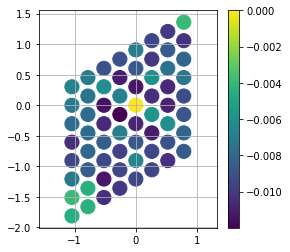

In [86]:
plt.figure(figsize=(4,4))
plt.scatter(q[:,0],q[:,1],c=chi0_q.real,s=200)
plt.axis('equal')
plt.grid()
plt.colorbar()

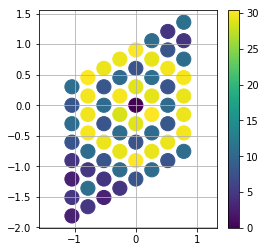

In [83]:
plt.figure(figsize=(4,4))
plt.scatter(q[:,0],q[:,1],c=W0_q.real,s=200)
plt.axis('equal')
plt.grid()
plt.colorbar()

Расчитаем $$\varepsilon_M(\omega)=1-\lim_{q\to 0,G\to 0}\frac{4\pi}{|q+G|^{2}}\sum_{vc}\sum_{k\in IBZ}\frac{|<vk|e^{i(q+G)r}|ck>|^{2}}{\omega+i\eta+\epsilon_{vk}-\epsilon_{ck}}$$

$$\lim_{q\to 0,G\to 0} <vk|e^{i(q+G)r}|ck>=q\frac{<vk|G|ck>}{\epsilon_{ck}-\epsilon_{vk}}$$

$$\varepsilon_M(\omega)=1-4\pi\sum_{vc}\sum_{k\in IBZ}\frac{|<vk|G|ck>|^{2}}{(\omega+i\eta+\epsilon_{vk}-\epsilon_{ck})(\epsilon_{ck}-\epsilon_{vk})^{2}}$$

In [57]:
omega=np.linspace(0,30,3000)/Hartree;eta=0.01/Hartree
epsilon=np.zeros(omega.size,dtype=np.complex)
for k in tqdm(range(NK)):
    for v in vb:
        for c in cb:
            wf1=calc.wfs.get_wave_function_array(n=v,k=k,s=0,realspace=False)
            wf2=calc.wfs.get_wave_function_array(n=c,k=k,s=0,realspace=False)
            G_=calc.wfs.pd.get_reciprocal_vectors(q=k,add_q=True)
            ME=np.sum([calc.wfs.pd.integrate(wf1,G_[:,i]*wf2)/(EK[k,c]-EK[k,v]) for i in range(3)])
            denominator=(omega+1j*eta-EK[k,c]+EK[k,v])
            epsilon+=4*wk[k]*np.abs(ME)**2/denominator/volume
epsilon=1-4*np.pi*epsilon

100%|██████████| 6/6 [00:00<00:00, 17.29it/s]


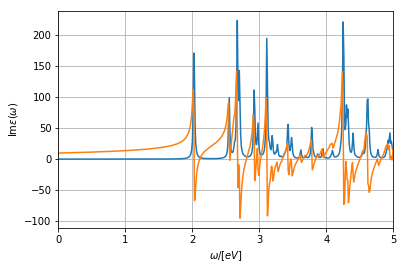

In [58]:
plt.plot(omega*Hartree,epsilon.imag)
plt.plot(omega*Hartree,epsilon.real)
plt.xlim([0,5])
plt.xlabel('$\\omega / [eV]$')
plt.ylabel('$\\mathrm{Im} \\epsilon(\\omega)$')
plt.grid()

# Проверим f-sum:

Получается:

In [59]:
print(np.trapz(epsilon.imag*omega,omega)*volume/(2*np.pi**2))

53.87180277437259


Должно быть:

In [60]:
calc.occupations.nvalence

26.0

Макроскопическая диэлектрическая константа:

In [61]:
epsilon[0].real

9.823585606690013